In [1]:
import sys
sys.path.append('..')

from common.utility import show_images, show_implementation
import numpy as np
from PIL import Image

In [2]:
rose_image = Image.open('images/rose.jpg').resize((288, 216))
rose_image_grey = np.array(rose_image.convert('L'))
rose_image_rgb = np.array(rose_image.convert('RGB'))

# Filtering
## Motivation
Suppose that we have two photos taken at similar time interval of the same static object.
Notice that the digital image formed will not be exactly the same, due to noise in the sensors and minor differences in lighting conditions.
Thus, we would wish to remove noise from our images.

## Types of noise
There are many types of noise, including

1. Salt and Pepper noise
    * Random occurrences of black and white pixels
    * Usually due to defects in the sensors.

2. Gaussian noise
    * Variation in intensity of each pixel drawn from a Gaussian distribution
    * Due to inherent noise of sensors and minute changes in lighting conditions.

In [3]:
from module.add_noise import salt_and_pepper, gaussian_noise
show_implementation(salt_and_pepper)
show_implementation(gaussian_noise)

def salt_and_pepper(img, prob=(0.02, 0.02)):

    img = np.array(img).astype(np.int16)
    
    mask = np.random.choice([-1, 0, 1], size=img.shape, p=[prob[0], 1-prob[0]-prob[1], prob[1]]).astype(np.int8)
    img = img + 255 * mask
    
    return np.clip(img, 0, 255)
def gaussian_noise(img, mu=0, sigma=20):

    img = np.array(img).astype(np.int16)
    mask = np.random.normal(mu, sigma, img.shape)
    img = img + mask
    
    return np.clip(img, 0, 255)


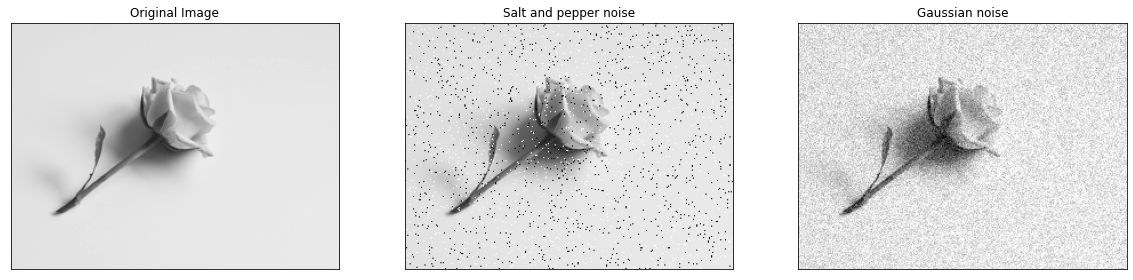

In [4]:
show_images([(rose_image_grey, 'Original Image'),
            (salt_and_pepper(rose_image_grey), 'Salt and pepper noise'),
            (gaussian_noise(rose_image_grey), 'Gaussian noise')
            ])

Suppose we plot the intensity plot around a noisy region.
We can make the assumption that noise correlate to the pixels whose intensity values are vastly different from its neighbours, like in the case of salt and pepper noise.
Thus, we can "smoothen" the image out by focusing on the average intensity values of the region in the image instead.

We can generalize and formalize this, where given image with pixel values of $p_{i, j}$, a window of size $2k+1 \times 2k+1$ where the center pixel is $f_{0,0}$, the resultant image $x$ is 

$$
x_{i,j} = \sum ^k _{u = -k} \sum ^k _{v = -k} f_{u, v} p_{i + u, j+v}
$$

(This operation is called **correlation filtering**)

Thus, suppose we wish to average the pixels in a $3\times 3$ area, then it simply corresponds to using a filter which is a $3\times 3$ grid of $\frac{1}{9}$.
The "averaging" filter is also known as a **box filter**.

Notice that because each pixel in the new image corresponds to a region in the original, the new image is smaller than the original image.
We can either accept this as it is, or we could pad the original image on all sides before filtering, to maintain the size of the resultant image; at the cost of some artifacts at the borders of the new image.

In [5]:
from module.correlate import correlate
show_implementation(correlate)

def correlate(img, window):

    height, width = img.shape
    
    assert window.shape[0] == window.shape[1]
    
    window_size = window.shape[0]
    
    new_image = np.zeros((height-window_size, width-window_size))
    
    for i in range(0, height - window_size):
        for j in range(0, width - window_size):
            new_image[i][j] = (window * img[i:i+window_size, j:j+window_size]).sum()
    return np.clip(new_image, 0, 255)


In [6]:
from module.kernel import box_filter
show_implementation(box_filter)

def box_filter(size):

    return np.ones((size, size))/size**2


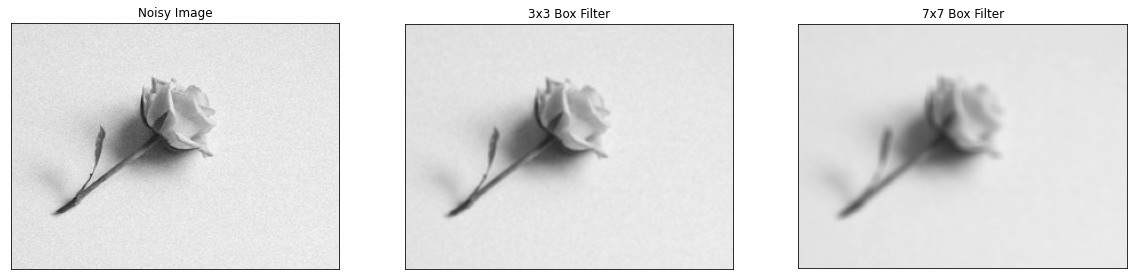

In [7]:
noisy_image = gaussian_noise(rose_image_grey, sigma=5)

show_images([(noisy_image, 'Noisy Image'),
            (correlate(noisy_image, box_filter(3)), '3x3 Box Filter'),
            (correlate(noisy_image, box_filter(7)), '7x7 Box Filter')
            ])

Notice that after filtering, the noise becomes less pronounced.
However, using a large window will blur the image.

## Gaussian Kernel

We can use a higher weight for the pixels that are closer to the center of the window, so that the resultant pixel intensity will be closer to that of the original pixel.
One easy filter to use is the Gaussian filter, where the center pixel has the value of 1, and the other pixel have smaller value the further it is from the center, as in a Gaussian function.
$\sigma$ controls how large the Gaussian kernel is, thus controlling the amount of smoothing.


In [8]:
from module.kernel import gaussian_filter
show_implementation(gaussian_filter)

def gaussian_filter(size, sigma=1):

    assert size % 2 == 1
    
    kernel = np.ones((size, size), np.float64)
    k = size // 2
    for i in range(size):
        for j in range(size):
            exponent = -((i - k)**2 + (j-k)**2) / (2 * sigma**2) 
            kernel[i][j] = np.exp(exponent)/ (2 * np.pi*sigma**2)
    return kernel


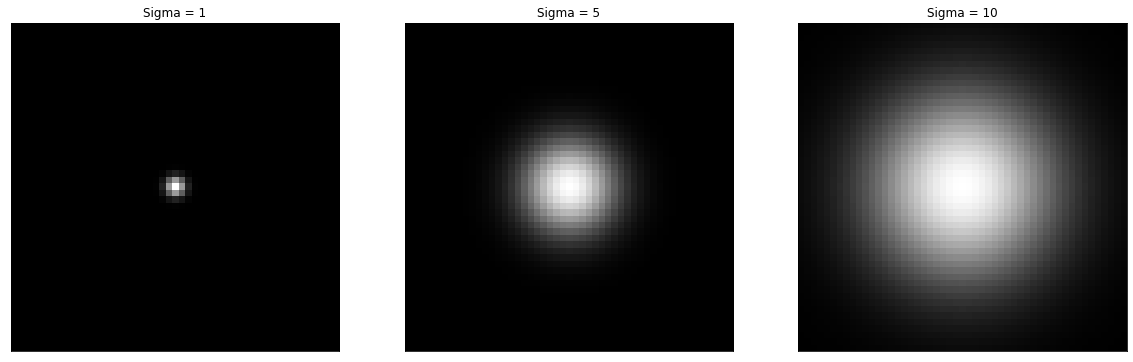

In [9]:
noisy_image = gaussian_noise(rose_image_grey, sigma=5)

show_images([(gaussian_filter(51, 1), "Sigma = 1"),
            (gaussian_filter(51, 5), "Sigma = 5"),
            (gaussian_filter(51, 10), "Sigma = 10")], autoscale=True)

(Note that we scaled intensity values of the kernels with the larger sigmas, otherwise it will not be visible. Thus in actuality, the kernel with sigma=10 brightness spot is not equally as bright as that of sigma=1)

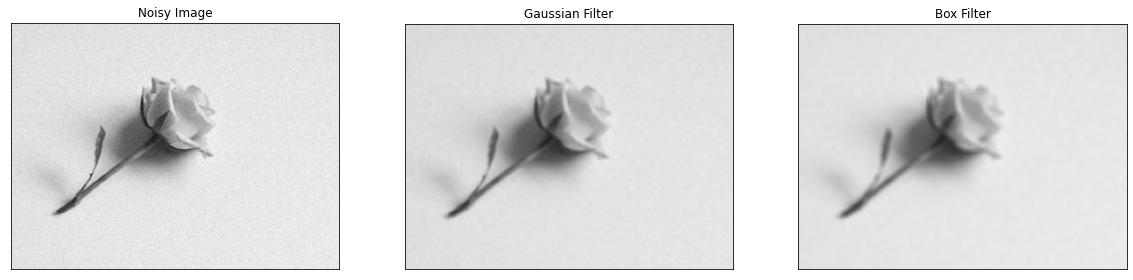

In [10]:
show_images([(noisy_image, 'Noisy Image'),
            (correlate(noisy_image, window=gaussian_filter(5, 1)), 'Gaussian Filter'),
            (correlate(noisy_image, window=box_filter(5)), 'Box Filter')
            ])

Note that the Gaussian filter perform better than the box filter as it removes the noise better while not blurring as much.

## Kernels as Transformations


Suppose that we used a kernel as below

$$
f = 
\begin{pmatrix}
0 & 0 & 0 \\
0 & 0 & 1 \\
0 & 0 & 0
\end{pmatrix}
$$

What would the resulting image be?

Since each pixel coordinate in the new image takes the value of the pixel to the right of it, this means that the resultant image will be shifted to the left.

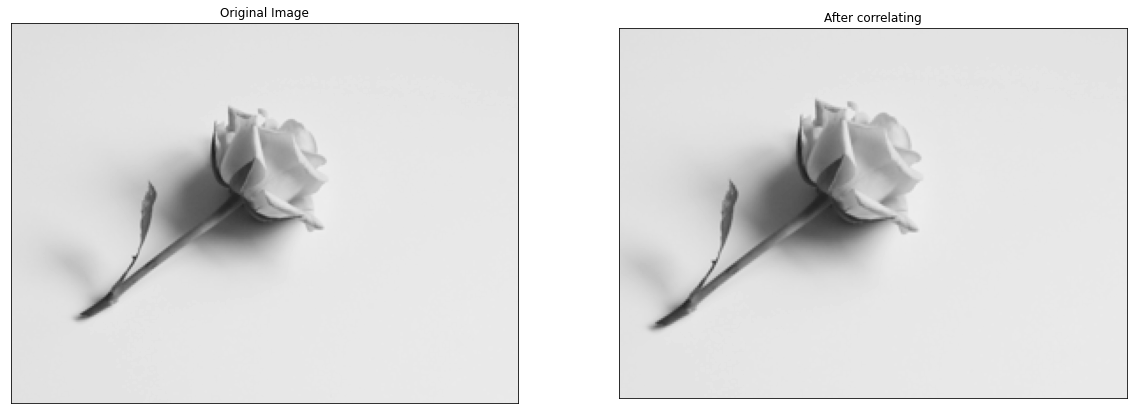

In [11]:
kernel = np.zeros((21, 21))
kernel[10][20] = 1

show_images([(rose_image_grey, 'Original Image'),
            (correlate(rose_image_grey, window=kernel), 'After correlating'),
            ])

(We used a 21x21 kernel instead to exaggerate the effects)

This tells us that we can do some transformation operations using correlation on the appropriate kernels.

What about the kernel below?


$$
f = 
\begin{pmatrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0
\end{pmatrix}
$$

It is clear that the resulting image will be identical to the original image.

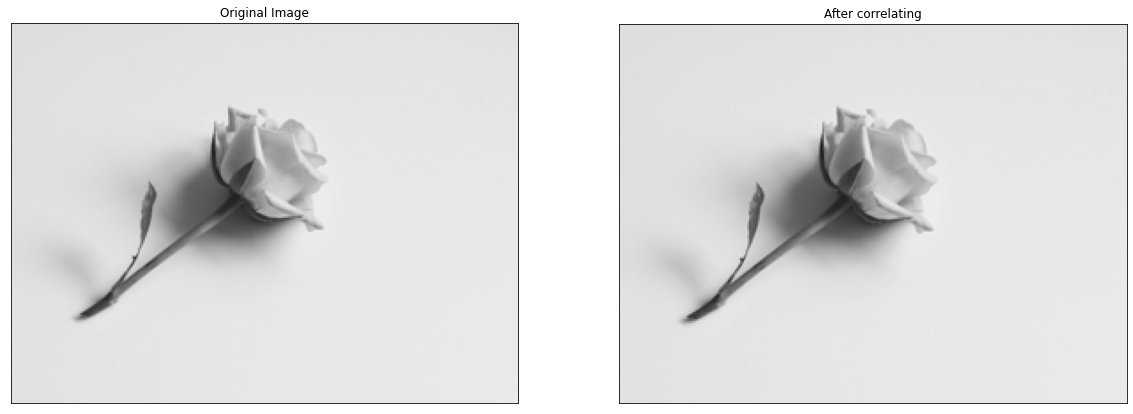

In [12]:
identity_kernel = np.zeros((3, 3))
identity_kernel[1][1] = 1

show_images([(rose_image_grey, 'Original Image'),
            (correlate(rose_image_grey, window=identity_kernel), 'After correlating'),
            ])

## Sharpening
Suppose we apply correlation using the below kernel

$$
f = 
\begin{pmatrix}
-1/9 & -1/9 & -1/9\\
-1/9 & 17/9 & -1/9\\
-1/9 & -1/9 & -1/9\\
\end{pmatrix}
$$

Notice that this kernel can be decomposed as below
$$
f = 
\begin{pmatrix}
-1/9 & -1/9 & -1/9\\
-1/9 & 17/9 & -1/9\\
-1/9 & -1/9 & -1/9\\
\end{pmatrix}
= 
\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1\\
\end{pmatrix}
+
\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1\\
\end{pmatrix}
-
\begin{pmatrix}
1/9 & 1/9 & 1/9\\
1/9 & 1/9 & 1/9\\
1/9 & 1/9 & 1/9\\
\end{pmatrix}
= 
\underbrace{
\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1\\
\end{pmatrix}}_{A}
+
\underbrace{
\left(
\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1\\
\end{pmatrix}
-
\begin{pmatrix}
1/9 & 1/9 & 1/9\\
1/9 & 1/9 & 1/9\\
1/9 & 1/9 & 1/9\\
\end{pmatrix}
\right)}_{B}
$$

$A$ is just the image itself.
$B$ is the image subtracted with the box filter blur of the time, which corresponds to how different each pixel value is from its neighbours.

What would the result be if we correlate using it?

Notice since we add the regions which are different from the neighbours this will emphasise the differences between each pixel, thus sharpening the image.

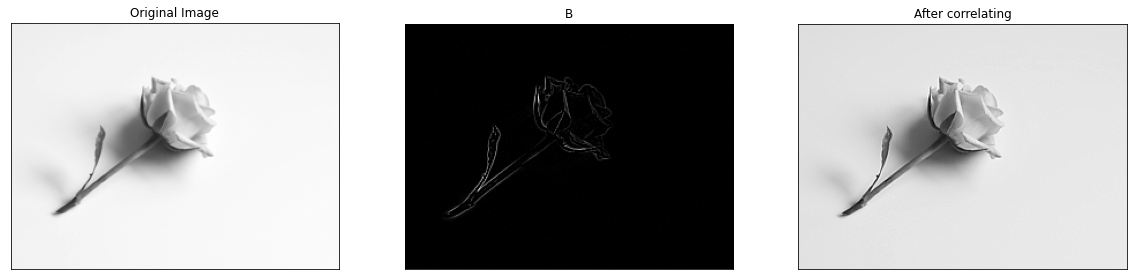

In [13]:
local_diff_kernel = -np.ones((3, 3)) / 9
local_diff_kernel[1][1] = 8/9

sharpen_kernel = -np.ones((3, 3)) / 9
sharpen_kernel[1][1] = 17/9

show_images([(rose_image_grey, 'Original Image'),
            (correlate(rose_image_grey, window=local_diff_kernel), 'B'),
            (correlate(rose_image_grey, window=sharpen_kernel), 'After correlating'),
            ], autoscale=True)

In [14]:
from module.point_process import adjust_contrast

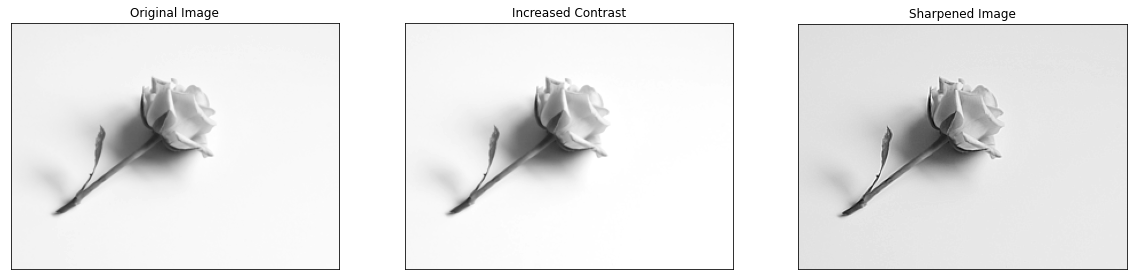

In [15]:
show_images([(rose_image_grey, 'Original Image'),
            (adjust_contrast(rose_image_grey, 1.1), 'Increased Contrast'),
            (correlate(rose_image_grey, window=sharpen_kernel), 'Sharpened Image'),
            ], autoscale=True)

Notice that unlike increasing contrast, sharpening will have little to no effect on areas in the image where the pixel values are similar; increasing contrast will scale all the pixel intensity by the same amount instead, making them brighter.

Thus, sharpening will emphasise the intensity peaks and differences compared to the surrounding pixels.

Consider the below situation, where we apply sharpening each image matrix below

* Flat region
    * There is no change
* Region with edge
    * Edge gets emphasised
* Flat region with noise
    * Noise is also emphasised

## Template matching
Suppose that we have a region of pixels that we wish to find.
This region is called the "template"